In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.datasets import Flowers102
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
from torchvision.io import read_image
from fastai.vision.all import *
from natsort import natsorted
import gc
import scipy.io
from utils import *
import cv2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
clear_gpu_cache()

cpu


#### EDA

In [2]:
split = scipy.io.loadmat('official_data/setid.mat')
split

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Feb 19 17:38:58 2009',
 '__version__': '1.0',
 '__globals__': [],
 'trnid': array([[6765, 6755, 6768, ..., 8026, 8036, 8041]], dtype=uint16),
 'valid': array([[6773, 6767, 6739, ..., 8028, 8008, 8030]], dtype=uint16),
 'tstid': array([[6734, 6735, 6737, ..., 8044, 8045, 8047]], dtype=uint16)}

In [3]:
# Subtract 1 to make index start from 0
train_inds = split['trnid'].flatten() - 1 
val_inds = split['valid'].flatten() - 1
test_inds = split['tstid'].flatten() - 1

print('Min indexes: ', train_inds.min(), val_inds.min(), test_inds.min())
print('Max indexes: ', train_inds.max(), val_inds.max(), test_inds.max())
print('   Size    : ', train_inds.shape[0], val_inds.shape[0], test_inds.shape[0])

Min indexes:  27 16 0
Max indexes:  8176 8186 8188
   Size    :  1020 1020 6149


In [4]:
labels_file = scipy.io.loadmat('official_data/imagelabels.mat')
labels_file

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Feb 19 15:43:33 2009',
 '__version__': '1.0',
 '__globals__': [],
 'labels': array([[77, 77, 77, ..., 62, 62, 62]], dtype=uint8)}

In [5]:
labels = labels_file['labels']
labels = labels.flatten() - 1  # to make it start from 0 to 101
print('labels shape', labels.shape)
print('First class index: ', labels.min(), ' Last class index: ', labels.max())

train_labels = torch.from_numpy(labels[train_inds]); print(len(train_labels), 'train labels: ', train_labels)
val_labels = torch.from_numpy(labels[val_inds]); print(len(val_labels), 'val labels: ', val_labels)
test_labels = torch.from_numpy(labels[test_inds]); print(len(test_labels), 'test labels: ', test_labels)

labels shape (8189,)
First class index:  0  Last class index:  101
1020 train labels:  tensor([  0,   0,   0,  ..., 101, 101, 101], dtype=torch.uint8)
1020 val labels:  tensor([  0,   0,   0,  ..., 101, 101, 101], dtype=torch.uint8)
6149 test labels:  tensor([  0,   0,   0,  ..., 101, 101, 101], dtype=torch.uint8)


In [6]:
all_files = get_image_files('official_data/102flowers/jpg/')

train_files = all_files[train_inds]; print('train_files: ', len(train_files))
val_files = all_files[val_inds]; print('val_files: ', len(val_files))
test_files = all_files[test_inds]; print('test_files: ', len(test_files))

train_files:  1020
val_files:  1020
test_files:  6149


In [7]:
class Flowers_102(Dataset):
    def __init__(self, pths, targets, transform = None, target_transform = None):
        self.pths = pths
        self.targets = targets
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.pths)
    
    def __getitem__(self, idx):
        im_pth = str(self.pths[idx])
        image = Image.fromarray(cv2.cvtColor(cv2.imread(im_pth), cv2.COLOR_BGR2RGB))
        label = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
            
        if self.target_transform:
            image = self.target_transform
            
        return image, label
    

In [8]:
to_tensor = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),])

In [9]:
# # Pytorch In-built dataset

# train_ds = Flowers102(root = './data', split = 'train', transform= to_tensor, download= True)
# val_ds= Flowers102(root = './data', split = 'val', transform= to_tensor, download= True)
# test_ds = Flowers102(root = './data', split = 'test', transform= to_tensor, download= True)

train_ds = Flowers_102(pths = train_files, targets= train_labels, transform=to_tensor)
val_ds = Flowers_102(val_files, val_labels, transform=to_tensor)
test_ds = Flowers_102(test_files, test_labels, transform=to_tensor)

bs = 32

train_loader = DataLoader(train_ds, batch_size = bs, shuffle = True)
val_loader = DataLoader(val_ds, batch_size = bs, shuffle = False)
test_loader = DataLoader(test_ds, batch_size = bs, shuffle = False)

X, y = next(iter(train_loader))
print(X.shape, y.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32])


In [10]:
train_counts_dict = class_distribution_dataloader(train_loader)
val_counts_dict = class_distribution_dataloader(val_loader)
test_counts_dict =  class_distribution_dataloader(test_loader)

print('class: train: val: test')
for k in natsorted(list(train_counts_dict.keys())):
    print(f"  {k}:  {train_counts_dict[k]} : {val_counts_dict[k]} : {test_counts_dict[k]}")

class: train: val: test
  0:  10 : 10 : 20
  1:  10 : 10 : 40
  2:  10 : 10 : 20
  3:  10 : 10 : 36
  4:  10 : 10 : 45
  5:  10 : 10 : 25
  6:  10 : 10 : 20
  7:  10 : 10 : 65
  8:  10 : 10 : 26
  9:  10 : 10 : 25
  10:  10 : 10 : 67
  11:  10 : 10 : 67
  12:  10 : 10 : 29
  13:  10 : 10 : 28
  14:  10 : 10 : 29
  15:  10 : 10 : 21
  16:  10 : 10 : 65
  17:  10 : 10 : 62
  18:  10 : 10 : 29
  19:  10 : 10 : 36
  20:  10 : 10 : 20
  21:  10 : 10 : 39
  22:  10 : 10 : 71
  23:  10 : 10 : 22
  24:  10 : 10 : 21
  25:  10 : 10 : 21
  26:  10 : 10 : 20
  27:  10 : 10 : 46
  28:  10 : 10 : 58
  29:  10 : 10 : 65
  30:  10 : 10 : 32
  31:  10 : 10 : 25
  32:  10 : 10 : 26
  33:  10 : 10 : 20
  34:  10 : 10 : 23
  35:  10 : 10 : 55
  36:  10 : 10 : 88
  37:  10 : 10 : 36
  38:  10 : 10 : 21
  39:  10 : 10 : 47
  40:  10 : 10 : 107
  41:  10 : 10 : 39
  42:  10 : 10 : 110
  43:  10 : 10 : 73
  44:  10 : 10 : 20
  45:  10 : 10 : 176
  46:  10 : 10 : 47
  47:  10 : 10 : 51
  48:  10 : 10 : 29
  4

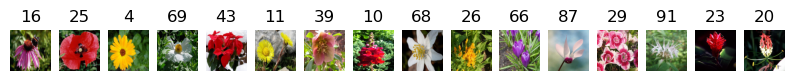

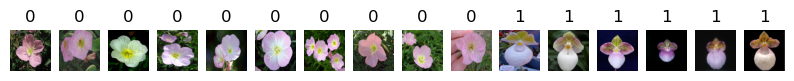

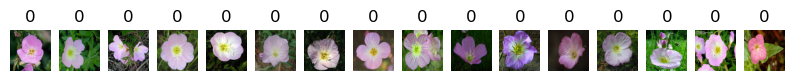

In [11]:
plot_train_val_batches([train_loader, val_loader, test_loader], invTrans, 1)

total params for finetuning entire network:  23717030


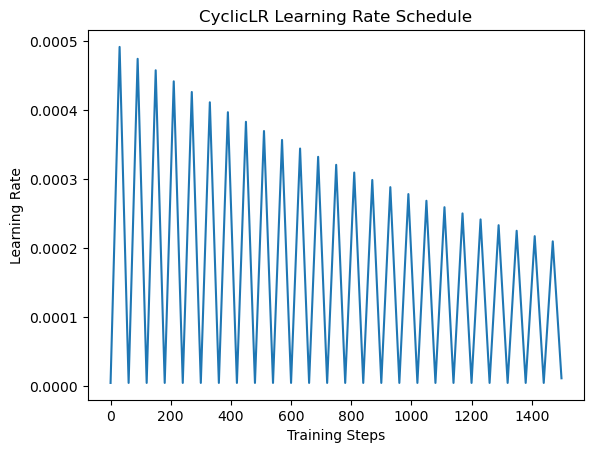

In [16]:
num_classes = 102
model = torchvision.models.resnet50(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# count trainable params
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('total params for finetuning entire network: ', num_trainable_params)


# Training setting and Hyperparameters
epochs = 50
lr = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)
patience = 5

# CyclicLR scheduler -> applied after every batch
    # My train dataset has len ~1020 and with bs = 32 => 30 iterations per epoch =>  50 epochs means a total of 1500 iterations 
    # Keep cycle of 2 epochs ~ 60 => step_size_up = 30

base_lr = 5e-6
max_lr = 5e-4
step_size_up = 30
mode = 'exp_range'

plot_lr_schedule(base_lr, max_lr, step_size_up, epochs, num_minibatches_per_epoch=30, mode = 'exp_range')

scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr, step_size_up=step_size_up, 
    mode=mode, gamma = 0.9994,cycle_momentum=False, base_momentum=0.8, max_momentum=0.9)

In [17]:
# train the model
tag = 'rn50_best_v2'
train_supervised(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, patience, tag, device)

Validation loss decreased (inf --> 2.213243).  Saving model ...
Epoch 1/50  Time: 22.35726237297058 sec
Training Loss: 3.9630,   Training Accuracy: 0.1824
Validation Loss: 2.2132, Validation Accuracy: 0.4608

Validation loss decreased (2.213243 --> 1.064630).  Saving model ...
Epoch 2/50  Time: 22.431214809417725 sec
Training Loss: 1.3255,   Training Accuracy: 0.7902
Validation Loss: 1.0646, Validation Accuracy: 0.8343

Validation loss decreased (1.064630 --> 0.895744).  Saving model ...
Epoch 3/50  Time: 22.444521188735962 sec
Training Loss: 0.4203,   Training Accuracy: 0.9667
Validation Loss: 0.8957, Validation Accuracy: 0.8020

Validation loss decreased (0.895744 --> 0.527987).  Saving model ...
Epoch 4/50  Time: 22.374984741210938 sec
Training Loss: 0.1379,   Training Accuracy: 0.9892
Validation Loss: 0.5280, Validation Accuracy: 0.8961

EarlyStopping counter: 1 out of 5
Epoch 5/50  Time: 22.675719499588013 sec
Training Loss: 0.0558,   Training Accuracy: 0.9980
Validation Loss: 0.5

In [18]:
# Evaluate performance on test set
model = torch.load('rn50_best_v2.pth')
model = model.to(device)
test_model(model, test_loader, criterion)

Test Loss: 0.3946, Test Accuracy: 0.9060


####  > Benchmark: 90.6.00% : no augmentations

Until now we have not used augmentations and number of training images are only 10 per class. With such minimal dataset, we acheived ~ 90.6% accuracy - Not bad!

__Let's see if we can further improve it by including image augmentations.__

In [2]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop((224, 224), scale = (0.08, 1.0), ratio = (0.85, 1.25)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_ds = Flowers_102(pths = train_files, targets= train_labels, transform=train_transform)
val_ds = Flowers_102(val_files, val_labels, transform=train_transform) # let's apply same augmentations to val set to make it a bit more difficult
test_ds = Flowers_102(test_files, test_labels, transform=test_transform)

bs = 32

train_loader = DataLoader(train_ds, batch_size = bs, shuffle = True)
val_loader = DataLoader(val_ds, batch_size = bs, shuffle = False)
test_loader = DataLoader(test_ds, batch_size = bs, shuffle = False)

X, y = next(iter(train_loader))
print(X.shape, y.shape)

plot_train_val_batches([train_loader, val_loader, test_loader], invTrans, 1)

In [ ]:
num_classes = 102
model = torchvision.models.resnet50(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# count trainable params
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('total params for finetuning entire network: ', num_trainable_params)


# Training setting and Hyperparameters
epochs = 200
lr = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)
patience = 5

# CyclicLR scheduler -> applied after every batch
    # My train dataset has len ~1020 and with bs = 32 => 30 iterations per epoch =>  50 epochs means a total of 1500 iterations 
    # Keep cycle of 2 epochs ~ 60 => step_size_up = 30

base_lr = 5e-6
max_lr = 5e-4
step_size_up = 30
mode = 'exp_range'

plot_lr_schedule(base_lr, max_lr, step_size_up, epochs, num_minibatches_per_epoch=30, mode = 'exp_range')

scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr, step_size_up=step_size_up, 
    mode=mode, gamma = 0.9994,cycle_momentum=False, base_momentum=0.8, max_momentum=0.9)

# train the model
tag = 'rn50_best_v2_aug'
train_supervised(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, patience, tag, device)

In [ ]:
# Evaluate performance on test set
model = torch.load('rn50_best_v2_aug.pth')
model = model.to(device)
test_model(model, test_loader, criterion)

There is another way to create augmentations - where we could create `n_augmentations` per image in training dataset. For this refer to <a href="https://github.com/mgupta70/code-blocks/blob/main/Image_classification/DL_Image_Augmentations.ipynb"> __this notebook__ </a> to see how it is done. I believe this should give more or less the similar results becuase technically it is not very different than what we are doing here.

__Since we have only 10 images for training and 10 for validation, may be it is a good idea to explore few-shot learning__

We will do this via `easyfsl` library

Stay tuned!